In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
engagement = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv',encoding = "ISO-8859-1")

In [3]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp']).dt.date


In [7]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22,1,1
1,2013-11-15,2,1
2,2013-11-29,2,1
3,2013-12-09,2,1
4,2013-12-25,2,1


In [8]:
engagement['visited'].unique()

array([1])

In [9]:
engagement = engagement.set_index(pd.DatetimeIndex(engagement['time_stamp'])).drop(columns='time_stamp')

In [10]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 to 2014-01-26
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  207917 non-null  int64
 1   visited  207917 non-null  int64
dtypes: int64(2)
memory usage: 4.8 MB


In [11]:
adopted_users = engagement.groupby('user_id').rolling('7D').visited.count().groupby('user_id').max().reset_index()

In [12]:
adopted_users.head(5)

,user_id,visited
0,1,1.0
1,2,3.0
2,3,1.0
3,4,1.0
4,5,1.0


In [13]:
def map_users(x):
    if x >= 3:
        return 1
    else:
        return 0
adopted_users['adopted_user'] = adopted_users['visited'].apply(map_users)

In [14]:
adopted_users.head(3)

,user_id,visited,adopted_user
0,1,1.0,0
1,2,3.0,1
2,3,1.0,0


In [15]:
 relax_users = pd.merge(users,adopted_users[['user_id','adopted_user']],left_on='object_id', right_on='user_id', how='left').drop(columns='user_id')

In [16]:
relax_users.fillna(0, inplace=True)

In [17]:
relax_users['adopted_user'] = relax_users.adopted_user.astype('int64')
relax_users['creation_source'] = relax_users['creation_source'].astype('category')

In [18]:
relax_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   object_id                   12000 non-null  int64   
 1   creation_time               12000 non-null  object  
 2   name                        12000 non-null  object  
 3   email                       12000 non-null  object  
 4   creation_source             12000 non-null  category
 5   last_session_creation_time  12000 non-null  float64 
 6   opted_in_to_mailing_list    12000 non-null  int64   
 7   enabled_for_marketing_drip  12000 non-null  int64   
 8   org_id                      12000 non-null  int64   
 9   invited_by_user_id          12000 non-null  float64 
 10  adopted_user                12000 non-null  int64   
dtypes: category(1), float64(2), int64(5), object(3)
memory usage: 1.0+ MB


In [19]:
relax_users["creation_source_cat"] = relax_users['creation_source'].cat.codes

In [20]:
relax_data = relax_users[['adopted_user','creation_source_cat','last_session_creation_time','opted_in_to_mailing_list',
                         'enabled_for_marketing_drip','org_id','invited_by_user_id']]

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2599
           1       0.71      0.60      0.65       401

    accuracy                           0.91      3000
   macro avg       0.83      0.78      0.80      3000
weighted avg       0.91      0.91      0.91      3000



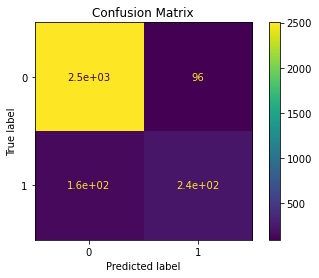

In [21]:
model = XGBClassifier()

X = relax_data.drop('adopted_user',axis=1)
y = relax_data['adopted_user']

#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=21)

model.fit(X_train,y_train)

#test model
y_pred = model.predict(X_test)
    
#print score and confusion matrix
print(classification_report(y_test, y_pred, zero_division=0))
plot_confusion_matrix(model, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

[0.09535298 0.51699734 0.08381185 0.09517273 0.10053007 0.10813513]


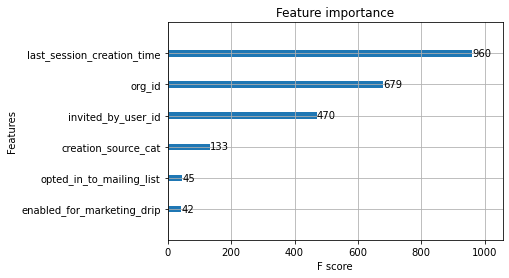

In [22]:
# feature importance
print(model.feature_importances_)
# plot
plot_importance(model)
plt.show()

### Conclusion

Feature importance scores indicate that last session creation time is the most salient feature when determining active users. This makes sense because if the user recently signed in, especially for legacy users, they are more than likely active. The second important feature is org_id which also makes sense because if users are associated with an organization that is working on a project or have coworkers who are active they have a higher likelihood of being active. 

It would be interesting to know the dates of marketing campaigns to analyze if they have any impact on user engagement. 